based on:

https://cms-opendata-workshop.github.io/workshop2021-lesson-introtrigger/01-introduction/index.html

https://twiki.cern.ch/twiki/bin/viewauth/CMS/SWGuideCMSDataAnalysisSchoolCERN2023HWWLongExercise

In [1]:
import hist
import warnings
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

warnings.filterwarnings("ignore", message="Missing cross-reference index ")

fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/2A2F4EC9-F9BB-DF43-B08D-525B5389937E.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

### **Triggers**

Collisions at the LHC happen at a rate close to 40 million per second (40 MHz). Once each collision is sensed by the different subdetectors, the amount of information they generate for each one of them corresponds to about what you can fit in a 1 MB file. If we were to record every single collision, it is said (you can do the math) that one can probably fill out all the available disk space in the world in a few days!

Fortunately, as you know, not all collisions that happen at the LHC are interesting, so we do not have to record every single one of them. We want to keep the interesting ones and, most importantly, do not miss the discovery-quality ones. In order to achieve that we need a Trigger.

Deciding on which events to record is the main purpose of the trigger system. It is like deciding which events to record by taking a quick picture of it and, even though a bit blurry, decide whether it is interesting to keep or not for a future, more thorough inspection.

There are hundreds of different triggers in CMS. Each one of them is designed to pick certain types of events, with different intensities and topologies. For instance the `IsoMu27` trigger, will select events with at least one muon with 27 GeV of transverse momentum.

In datasets we have flags for the different trigger bits, basically events that do not pass the trigger are weighted 0, those that pass are weighted 1

In [2]:
# analysis trigger
trigger = "IsoMu27"

# access high level trigger mask
trigger_mask = events.HLT[trigger]
trigger_mask

<Array [False, False, False, ... False, True] type='1280000 * bool[parameters={"...'>

### **MET filters**

Similar to the trigger flag, there is a flag that tells whether the event passes a series of filters devised by the JetMET POG to filter anomalous MET events (MC version)

In [3]:
met_filters = [
    "goodVertices",
    "globalSuperTightHalo2016Filter",
    "HBHENoiseFilter",
    "HBHENoiseIsoFilter",
    "EcalDeadCellTriggerPrimitiveFilter",
    "BadPFMuonFilter",
    "BadPFMuonDzFilter",
    "eeBadScFilter",
    "ecalBadCalibFilter"
]

met_filters_mask = np.ones(len(events), dtype="bool")
for mf in met_filters:
    if mf in events.Flag.fields:
        met_filters_mask = met_filters_mask & events.Flag[mf]
        
met_filters_mask

<Array [True, True, True, ... True, True, True] type='1280000 * bool'>

**manipulating selections**

Coffea provide the `PackedSelection` class that can store several boolean arrays in a memory-efficient mannner
and evaluate arbitrary combinations of boolean requirements in an CPU-efficient way (supported inputs are 1D numpy or awkward arrays). 

We can add selections (boolean masks) using the `add()` method:

In [4]:
from coffea.analysis_tools import PackedSelection

# create an instance of PackedSelections
selections = PackedSelection()

# add trigger mask
selections.add("trigger", trigger_mask)

# add met filters mask
selections.add("metfilters", met_filters_mask)

# add leading muon selections
selections.add("leading_muon_pt", ak.firsts(events.Muon).pt > 50)

Then, we can access the combination (logic AND operation) of some masks using the `all()` method

In [5]:
# combining the 'trigger' and 'metfilters'
selections.all("trigger", "metfilters")

array([False, False, False, ..., False, False,  True])

In [6]:
# combining all selections
selections.all("trigger", "metfilters", "leading_muon_pt")

array([False, False, False, ..., False, False,  True])

# **Weights and corrections**

MC and data have several weights. MC weights are needed first and foremost to normalize the MC sample to the luminosity of the data. Also, event weights are computed to take into account the different scale factors that we use to improve the description of the data.

Scale factors (SF) are corrections applied to MC samples to fix imperfections in the simulation. The origin of the mis-modelling could be from the hard scattering (theory uncertainty), or from the simulation of the response of particles with the detector (Geant4), or due to the conditions evolution in time in data (the MC has only one set of conditions), such as noise and radiation damage effects on the detectors

We can access certain correction weights directly from the NanoAOD:

**Generation weights**

In the generation of MC samples, the number of events may be underestimated or overestimated. Hence, these samples come with a weight (known as *genWeight*) that allows us to rectify this underestimation/overestimation.

In [7]:
gen_weight = events.genWeight
gen_weight

<Array [303, 303, 303, 303, ... 303, 303, 303] type='1280000 * float32[parameter...'>

**L1Prefiring weights**

In 2016 and 2017, the gradual timing shift of ECAL was not properly propagated to L1 trigger primitives (TP) resulting in a significant fraction of high $\eta$ TP being mistakenly associated to the previous bunch crossing. Since Level 1 rules forbid two consecutive bunch crossings to fire, an unpleasant consequence of this (in addition to not finding the TP in the bx 0) is that events can self veto if a significant amount of ECAL energy is found in the region of 2.<|$\eta$|<3. This effect is not described by the simulations.

In [8]:
l1prefiring_weight = events.L1PreFiringWeight.Nom
l1prefiring_weight

<Array [0.976, 1, 0.992, ... 0.976, 0.941, 1] type='1280000 * float32[parameters...'>

### **Correctionlib**

Other corrections need to be computed using external tools. [Correctionlib](https://github.com/cms-nanoAOD/correctionlib) provide a well-structured JSON data format for a wide variety of ad-hoc correction factors encountered in a typical HEP analysis and a companion evaluation tool suitable for use in C++ and python programs. Here we restrict our definition of correction factors to a class of functions with scalar inputs that produce a scalar output.

In python, the function signature is:

```
def f(*args: str | int | float) -> float:
    return ...
```

All available corrections can be found [here](https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/)

**Pileup weights**

This weight is needed to equalize the Pile-Up profile in MC to that in Data. You need to understand that most of the time the simulation is done before, or at least partly before, the data taking, thus the PU profile in the MC is a guess of what will happen with data. This weight is the ratio of the PU profile in data to that guess that was used when producing the MC.

You can find the description of the pile up function correction [here](https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/summaries/LUM_2017_UL_puWeights.html) 

In [9]:
import correctionlib

# The SF themselves can be found in the central POG repository
pog_path = "/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration"

# path to the pileup correction set (2017 UL MC)
pileup_corrections_path = f"{pog_path}/POG/LUM/2017_UL/puWeights.json.gz"

# define correction set
cset = correctionlib.CorrectionSet.from_file(pileup_corrections_path)

# get pileup weights
pileup_weights = cset["Collisions17_UltraLegacy_goldenJSON"].evaluate(events.Pileup.nPU, "nominal")

**Manipulating weights**

Similar to `PackedSelection`, coffea provide the `Weights` container that keeps track of correction factors and systematic effects that can be encoded as multiplicative modifiers to the event weight (All weights are stored in vector form).

In [10]:
from coffea.analysis_tools import Weights

# create an instance of the Weights container
weights_container = Weights(size=len(events), storeIndividual=True)

# add nominal weights
weights_container.add("genweight", gen_weight)
weights_container.add("l1prefiring", l1prefiring_weight)
weights_container.add("pileup", pileup_weights)

Then, we can access the combination (multiplication) of all weights using the `weight()` method

In [11]:
weights_container.weight()

array([284.36289951, 278.48991972, 288.97276102, ..., 287.80464001,
       293.76914437, 305.73140573])

or a some weight(s) using the `partial_weight()` method

In [12]:
weights_container.partial_weight(include=["pileup", "l1prefiring"])

array([0.93738388, 0.91802398, 0.95257999, ..., 0.94872935, 0.96839095,
       1.00782377])

We can access to a statistical summary of the weights using the `weightStatistics` attribute

In [13]:
weights_container.weightStatistics

{'genweight': WeightStatistics(sumw=385119712.0, sumw2=117793308672.0, minw=-303.3580017089844, maxw=303.3580017089844, n=1280000),
 'l1prefiring': WeightStatistics(sumw=1240563.25, sumw2=1210608.5, minw=0.05073864385485649, maxw=1.0, n=1280000),
 'pileup': WeightStatistics(sumw=1346953.8990572663, sumw2=7886812.395507115, minw=0.5379188426448102, maxw=159.55129944394525, n=1280000)}

### **Normalize events to luminosity/cross section**

The number of expected events is given by

$$N = L \times \sigma \times \epsilon,$$

where $L$ is the integrated luminosity, $\sigma$ is the cross section of the process, and $\epsilon$ is the selection efficiency $\frac{N_{after}}{N_{before}}$. 

Notice that the addition of weights (scale factors) modify the number of events $N_{after}$ and $N_{before}$. These can be compute as the sum of the weights vector before and after selections:

In [14]:
# compute initial number of events (before selections)
sumw_before = ak.sum(weights_container.weight())

# define region selection
region_selection = selections.all("trigger", "metfilters", "leading_muon_pt")

# get region weight vector
region_weights = weights_container.weight()[region_selection]

# compute final number of events (after selections)
sumw_after = ak.sum(region_weights)

# compute selection efficiency
eff = sumw_after / sumw_before

# compute expected number of events
L = 41477.88
xsec = 365.34
L * xsec * eff

1730845.2092653676

This normalization should also be applied to the histograms

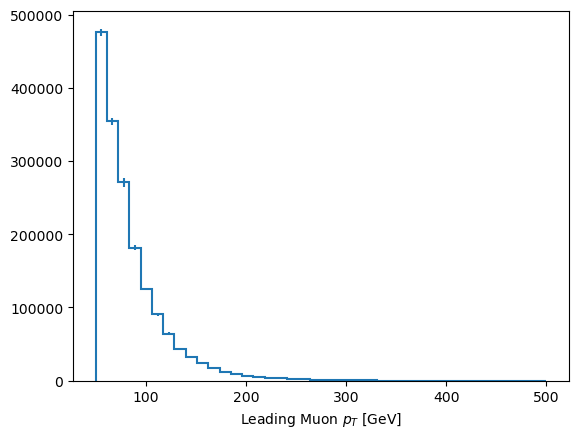

In [15]:
# histogram definition
muon_pt_axis = hist.axis.Regular(
    bins=40, 
    start=50, 
    stop=500, 
    name="muon_pt", 
    label="Leading Muon $p_T$ [GeV]"
)
muon_pt_histogram = hist.Hist(
    muon_pt_axis, # muon pt axis
    hist.storage.Weight(), # weight storage
)
# histogram filling
muon_pt_histogram.fill(
    muon_pt=ak.firsts(events.Muon.pt)[region_selection],
    weight=region_weights,
)
# normalize to luminosity/cross section
lumi_weight = (L * xsec) / sumw_before
muon_pt_histogram = muon_pt_histogram * lumi_weight
muon_pt_histogram.plot1d();

In [16]:
# total number of events in histogram
ak.sum(muon_pt_histogram.counts())

1730678.8045717229

### **Quiz**: 

Using the following dataset

`root://eospublic.cern.ch//eos/root-eos/HiggsTauTauReduced/DYJetsToLL.root`

* Compute the muon ID (`NUM_TightID_DEN_TrackerMuons`), Iso (`NUM_TightRelIso_DEN_TightIDandIPCut`) and TriggerIso (`NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight`) scale factors. Read the SF from `muon_Z.json.gz'`.


    **Hint 1** Corrections only apply to 1D arrays. Therefore, you must flatten (use `ak.flatten()` and `ak.num()`) the arrays to calculate the SF and then unflatten them to the original shape (use `ak.unflatten()`)
    
    **Hint 2** Note that in some corrections the variables are limited to a defined range (use `np.clip()` so values outside the interval are clipped to the interval edges). 
    
    
    **Hint 3:** The event scale factor is obtained by multiplying the scale factors of each object in the event (use `ak.prod()`).
    
* Compute the number of weighted events before any selection
* Select muons:
    * Muons with $p_T>35$ GeV
    * Muons with $|\eta|<2.4$
    * Muons identified with a tight working point (`tightId`)
    * Muons with tight relative isolation (`pfRelIso03_all < 0.15`)
* Select events:
    * Events triggered by `IsoMu24`
    * Events with missing energy (`MET > 50` GeV)
* Filter events and compute the number of weighted events after selection
* Compute the expected number of events ($L=41477.88$ and $\sigma=3503.7$)
* Define and plot histograms for leading muon's $p_T$, $\eta$ and $\phi$ (normalized to lumi/cross section)

In [17]:
# load events
fname = "root://eospublic.cern.ch//eos/root-eos/HiggsTauTauReduced/DYJetsToLL.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

# select muons
muons = events.Muon

# get correction set
cset = correctionlib.CorrectionSet.from_file("muon_Z.json.gz")

In [18]:
def print_correction(cset, name):
    inputs = cset[name].inputs
    output = cset[name].output
    print("Inputs:")
    for input_variable in inputs:
        print(f"{input_variable.name} (type: {input_variable.type}): {input_variable.description}\n")
    print("Output:")
    print(f"{output.name} (type: {output.type}): {output.description}\n")

#### ID SF

In [19]:
print_correction(cset, "NUM_TightID_DEN_TrackerMuons")

Inputs:
year (type: string): year/scenario: example 2016preVFP, 2017 etc

abseta (type: real): Probe abseta

pt (type: real): Probe pt

ValType (type: string): sf or syst (currently 'sf' is nominal, and 'systup' and 'systdown' are up/down variations with total stat+syst uncertainties. Individual systs are also available (in these cases syst only, not sf +/- syst)

Output:
weight (type: real): Output scale factor (nominal) or uncertainty



In [20]:
# flatten muons 
m, n = ak.flatten(muons), ak.num(muons)

# get mask for 'in-limits' muons
muon_pt_mask = m.pt > 15.
muon_eta_mask = np.abs(m.eta) < 2.4
muon_mask = muon_pt_mask & muon_eta_mask

# get 'in-limits' muons
in_limit_muons = m.mask[muon_mask]

# get pt and eta
# fill Nones with some 'in-limit' value
muon_pt = ak.fill_none(in_limit_muons.pt, 15.)
muon_eta = ak.fill_none(np.abs(in_limit_muons.eta), 0.)

# compute scale factors
id_sf = cset["NUM_TightID_DEN_TrackerMuons"].evaluate("2017_UL", muon_eta, muon_pt, "sf")

# if muon in 'in-limits' muons, then take the computed SF, otherwise assign 1
id_sf = ak.where(
    muon_mask,
    id_sf,
    ak.ones_like(id_sf)
)

# unflatten scale factors to original shape 
id_sf = ak.unflatten(id_sf, n)

# take the product of the scale factors along axis 1
id_sf = ak.prod(id_sf, axis=1)
id_sf

<Array [1, 0.99, 0.991, 1, ... 1, 0.989, 1, 1] type='3045887 * float64'>

#### Iso SF

In [21]:
print_correction(cset, "NUM_TightRelIso_DEN_TightIDandIPCut")

Inputs:
year (type: string): year/scenario: example 2016preVFP, 2017 etc

abseta (type: real): Probe abseta

pt (type: real): Probe pt

ValType (type: string): sf or syst (currently 'sf' is nominal, and 'systup' and 'systdown' are up/down variations with total stat+syst uncertainties. Individual systs are also available (in these cases syst only, not sf +/- syst)

Output:
weight (type: real): Output scale factor (nominal) or uncertainty



In [22]:
# flatten muons 
m, n = ak.flatten(muons), ak.num(muons)

# get mask for 'in-limits' muons
muon_pt_mask = m.pt > 15.
muon_eta_mask = np.abs(m.eta) < 2.4
muon_mask = muon_pt_mask & muon_eta_mask

# get 'in-limits' muons
in_limit_muons = m.mask[muon_mask]

# get pt and eta
# fill Nones with some 'in-limit' value
muon_pt = ak.fill_none(in_limit_muons.pt, 15.)
muon_eta = ak.fill_none(np.abs(in_limit_muons.eta), 0.)

# compute scale factors
iso_sf = cset["NUM_TightRelIso_DEN_TightIDandIPCut"].evaluate("2017_UL", muon_eta, muon_pt, "sf")

# if muon in 'in-limits' muons, then take the computed SF, otherwise assign 1
iso_sf = ak.where(
    muon_mask,
    iso_sf,
    ak.ones_like(iso_sf)
)
# unflatten scale factors to original shape and take the product of the scale factors along axis 1
iso_sf = ak.prod(ak.unflatten(iso_sf, n), axis=1)
iso_sf

<Array [1, 1, 1, 1, 1.02, ... 1, 0.997, 1, 1] type='3045887 * float64'>

#### TriggerIso SF

In [23]:
print_correction(cset, "NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight")

Inputs:
year (type: string): year/scenario: example 2016preVFP, 2017 etc

abseta (type: real): Probe abseta

pt (type: real): Probe pt

ValType (type: string): sf or syst (currently 'sf' is nominal, and 'systup' and 'systdown' are up/down variations with total stat+syst uncertainties. Individual systs are also available (in these cases syst only, not sf +/- syst)

Output:
weight (type: real): Output scale factor (nominal) or uncertainty



In [24]:
# flatten muons 
m, n = ak.flatten(muons), ak.num(muons)

# get mask for 'in-limits' muons
muon_pt_mask = m.pt > 29.
muon_eta_mask = np.abs(m.eta) < 2.4
muon_mask = muon_pt_mask & muon_eta_mask

# get 'in-limits' muons
in_limit_muons = m.mask[muon_mask]

# get pt and eta
# fill Nones with some 'in-limit' value
muon_pt = ak.fill_none(in_limit_muons.pt, 29.)
muon_eta = ak.fill_none(np.abs(in_limit_muons.eta), 0.)

# compute scale factors
triggeriso_sf = cset["NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight"].evaluate("2017_UL", muon_eta, muon_pt, "sf")

# if muon in 'in-limits' muons, then take the computed SF, otherwise assign 1
triggeriso_sf = ak.where(
    muon_mask,
    triggeriso_sf,
    ak.ones_like(triggeriso_sf)
)
# unflatten scale factors to original shape and take the product of the scale factors along axis 1
triggeriso_sf = ak.prod(ak.unflatten(triggeriso_sf, n), axis=1)
triggeriso_sf

<Array [1, 1, 1.02, 1, 1, 1, ... 1, 1, 1, 1, 1] type='3045887 * float64'>

### Compute the number of weighted events before any selection

In [25]:
# create an instance of the Weights container
weights_container = Weights(size=len(events), storeIndividual=True)

# add nominal weights
weights_container.add("id_sf", id_sf)
weights_container.add("iso_sf", iso_sf)
weights_container.add("triggeriso_sf", triggeriso_sf)

# sum of weights
sumw = ak.sum(weights_container.weight())
sumw

3019759.5278414087

### Select muons

In [26]:
good_muons = (
    (events.Muon.pt > 35)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso03_all < 0.15)
)
muons = events.Muon[good_muons]

### Select events

In [27]:
# create an instance of PackedSelections
selections = PackedSelection()

# add trigger mask
selections.add("trigger", events.HLT["IsoMu24"]) # we should use IsoMu27 but not present in MC sample

# add met filters mask
selections.add("met", events.MET.pt > 50)

### Filter events and compute the number of weighted events after selection

In [28]:
# define region mask
region = ["trigger", "met"]
region_selection_mask = selections.all(*region) # selections.all("trigger", "met")

# region weights
region_weights = weights_container.weight()[region_selection_mask]

# get sumw after selection
sumw_after = ak.sum(region_weights)

### Compute the expected number of events

In [29]:
L = 41477.88
xs = 3503.7

L * xs * (sumw_after / sumw)

1567984.0425020284

### Define and plot histograms for leading muon's  $𝑝_T$,  𝜂 and  𝜙 (normalized to lumi/cross section)

In [30]:
# histogram definition
leading_muon_pt_axis = hist.axis.Regular(
    bins=40, 
    start=35, 
    stop=200, 
    name="muon_pt", 
    label="Leading Muon $p_T$ [GeV]"
)
leading_muon_eta_axis = hist.axis.Regular(
    bins=40, 
    start=-2.4, 
    stop=2.4, 
    name="muon_eta", 
    label="Leading Muon $\eta$"
)
leading_muon_phi_axis = hist.axis.Regular(
    bins=40, 
    start=-np.pi, 
    stop=np.pi, 
    name="muon_phi", 
    label="Leading Muon $\phi$"
)
leading_muon_histogram = hist.Hist(
    leading_muon_pt_axis, 
    leading_muon_eta_axis, 
    leading_muon_phi_axis, 
    hist.storage.Weight(), 
)

In [31]:
# variables
# fill None values with underflow/overflow bins
muon_pt = ak.fill_none(ak.firsts(muons.pt[region_selection_mask]), -1)
muon_eta = ak.fill_none(ak.firsts(muons.eta[region_selection_mask]), -10)
muon_phi = ak.fill_none(ak.firsts(muons.phi[region_selection_mask]), -10)

In [32]:
# histogram filling
leading_muon_histogram.fill(
    muon_pt=muon_pt,
    muon_eta=muon_eta,
    muon_phi=muon_phi,
    weight=region_weights,
)
# normalize to luminosity/cross section
lumi_weight = (L * xsec) / sumw
leading_muon_histogram = leading_muon_histogram * lumi_weight

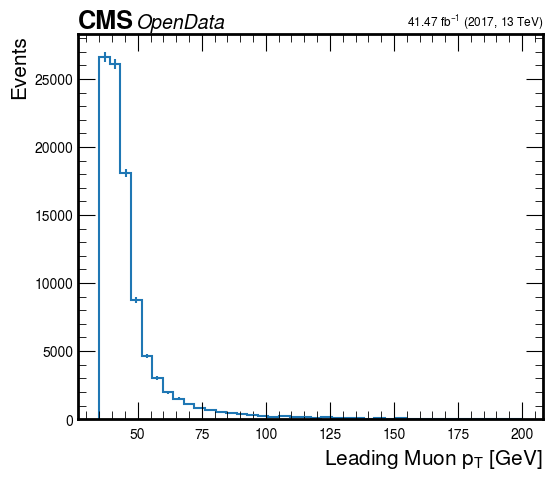

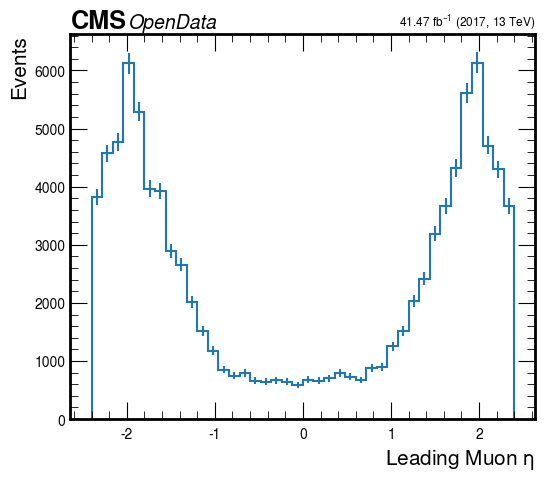

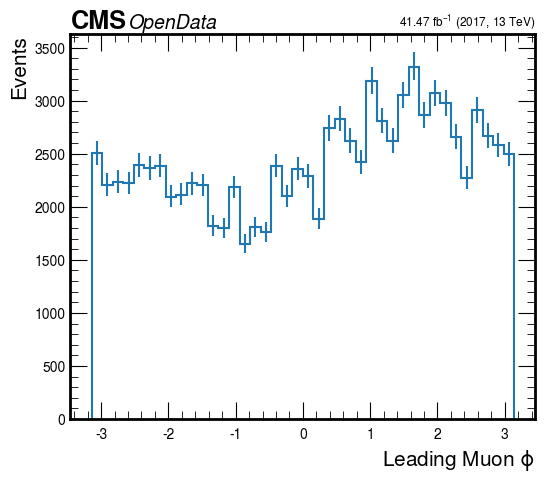

In [33]:
# plot variables
def plot_cms_histogram(hist_histogram, variable):
    import mplhep as hep
    hep.style.use(hep.style.CMS)
    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.titlesize": 14,
            "axes.labelsize": 15,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "lines.markersize": 4,
            "legend.fontsize": 10,
        }
    )
    fig, ax = plt.subplots(figsize=(6, 5))
    hist_histogram.project(variable).plot1d(ax=ax)
    ax.set(ylabel="Events")
    hep.cms.lumitext("41.47 fb$^{-1}$ (2017, 13 TeV)", fontsize=9, ax=ax)
    hep.cms.text("OpenData", loc=0, ax=ax)
    
plot_cms_histogram(leading_muon_histogram, "muon_pt")
plot_cms_histogram(leading_muon_histogram, "muon_eta")
plot_cms_histogram(leading_muon_histogram, "muon_phi")